Dataset taken from [here](https://www.kaggle.com/puneet6060/intel-image-classification)

In [1]:
%matplotlib inline
import os
from tensorflow.keras import layers, optimizers, regularizers, callbacks, Model, Input
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import clear_output
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image as pil_image
import numpy as np
import cv2, os
import time
import telegram_send
plt.style.use('seaborn-white')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


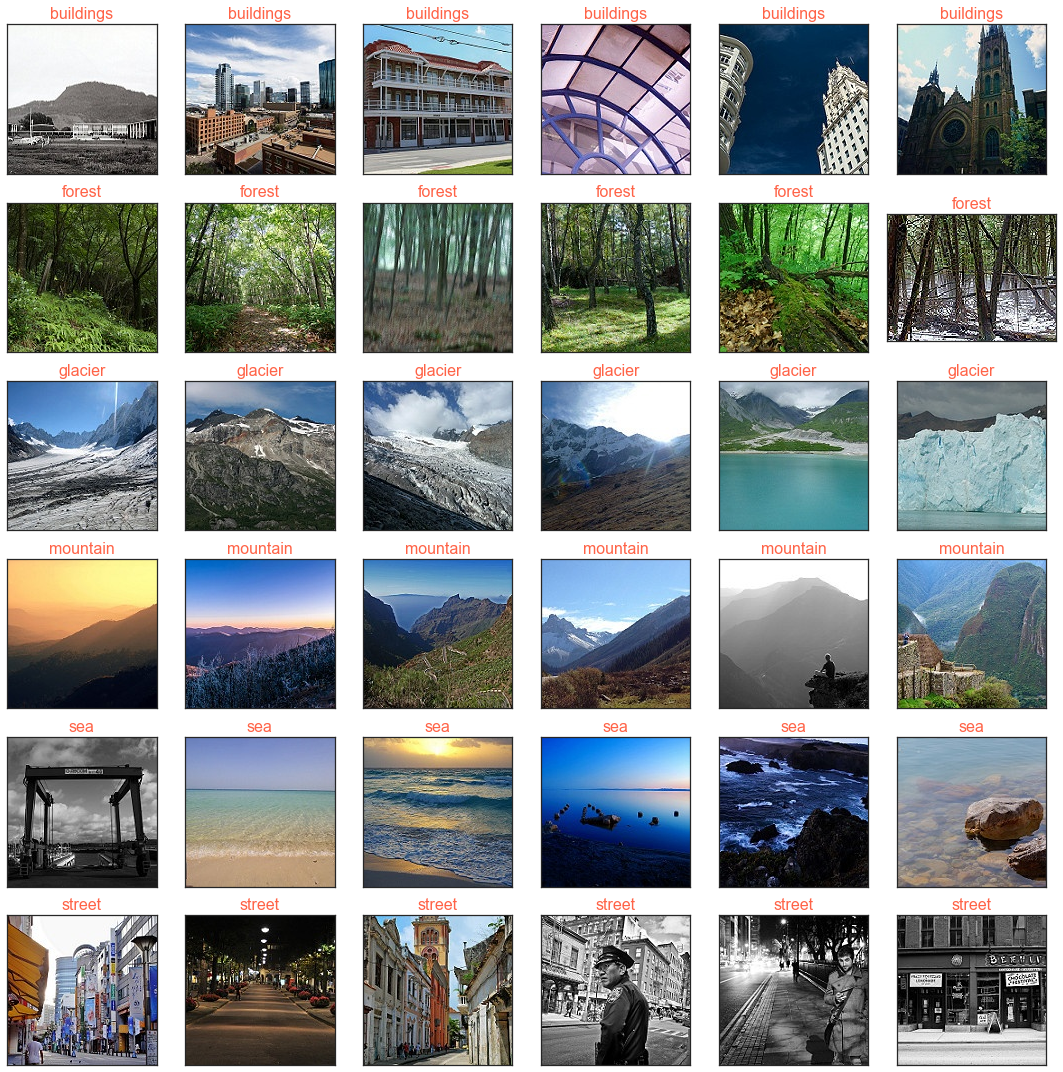

In [2]:
train_dataset_path = "../../datasets/intel_image/intel-image-classification/seg_train/seg_train"
test_dataset_path = "../../datasets/intel_image/intel-image-classification/seg_test/seg_test"
img_size = 64
batch_size = 64
categories = os.listdir(train_dataset_path)
num_classes = len(categories)
train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                horizontal_flip=True)
test_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
        train_dataset_path,
        target_size=(img_size, img_size),
        color_mode='rgb',
        batch_size=batch_size,
        shuffle=True,
        seed=0,
        class_mode="categorical")
test_generator = test_datagen.flow_from_directory(
        test_dataset_path,
        target_size=(img_size, img_size),
        color_mode='rgb',
        batch_size=batch_size,
        shuffle=True,
        seed=0,
        class_mode="categorical")
f, axes = plt.subplots(6, 6, figsize = (15, 15))
for i, category in enumerate(categories):
    path = train_dataset_path + '/' + category
    images = os.listdir(path)
    for j in range(6):
        image = cv2.imread(path + '/' + images[j])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[i, j].imshow(image)
        axes[i, j].set(xticks=[], yticks=[])
        axes[i, j].set_title(category, color = 'tomato').set_size(16)
plt.tight_layout()
callback_is_nan = callbacks.TerminateOnNaN()
callback_early = callbacks.EarlyStopping(monitor='loss', min_delta = .001, patience = 10)
class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show()
plot_losses = PlotLosses()
step_size_train=int(train_generator.n // train_generator.batch_size * 1.5)
step_size_valid=int(test_generator.n // test_generator.batch_size * 1.5)

In [3]:
def plot_accuracy(fig_path, history):
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    print('Training Accuracy: {:.3f}'.format(np.max(acc)))
    print('Training Loss: {:.3f}'.format(np.max(loss)))
    print('Validation Accuracy: {:.3f}'.format(np.max(val_acc)))
    print('Validation Loss: {:.3f}'.format(np.max(val_loss)))
    axes[0].plot(acc, label='Train')
    axes[0].plot(val_acc, label='Test')
    axes[0].set_title('Model accuracy')
    axes[0].set(ylabel = 'Accuracy', xlabel = 'Epoch')
    axes[0].legend()
    axes[1].plot(loss, label='Train')
    axes[1].plot(val_loss, label='Test')
    axes[1].set_title('Model loss')
    axes[1].set(ylabel = 'Loss', xlabel = 'Epoch')
    axes[1].legend()
    plt.show()
    f.savefig(f'{fig_path}')
    print('Saved figure at', f'{fig_path}')

[here](https://www.kaggle.com/drobchak1988/blood-cell-images-acc-92-val-acc-90)

In [4]:
def fire(x, f_map):
    y = layers.Conv2D(filters=f_map, kernel_size=1, padding='same')(x)
    y = layers.BatchNormalization(momentum=.85)(y)
    y = layers.ReLU()(y)
    y1 = layers.Conv2D(filters=f_map, kernel_size=5, padding='same')(y)
    y1 = layers.BatchNormalization(momentum=.85)(y1)
    y1 = layers.ReLU()(y1)
    y3 = layers.Conv2D(filters=f_map, kernel_size=3, padding='same')(y)
    y3 = layers.BatchNormalization(momentum=.85)(y3)
    y3 = layers.ReLU()(y3)
    return layers.concatenate([y1, y3])
def fire_module(f_map):
    return lambda x: fire(x, f_map)
def skip_module(x, f_map):
    x, skip = x
    skip = layers.Conv2D(filters = 2*f_map, kernel_size = 1, padding = 'same')(skip)
    x = layers.Add()([x, skip])
    x = layers.ReLU()(x)
    return x
def skip_connection(f_map):
    return lambda x: skip_module(x, f_map)
def notify(message=''):
    telegram_send.send(messages=['Finished running {}'.format(message)])

In [5]:
def train(lr,
          f_maps = [],
          optimizer = None,
          notification = True,
          epochs = 2,
          folder = None,
          dataset= None,
          fig_path = None,
          model_path = None):
    K.clear_session()
    inputs = layers.Input(shape=[img_size, img_size, 3])
    x = layers.Conv2D(kernel_size=7, filters=16, padding='same')(inputs)
    x = layers.BatchNormalization(momentum=.85)(x)
    x = layers.ReLU()(x)
    skip = x

    for f_map in f_maps:
        x = fire_module(f_map)(x)
        x = skip_connection(f_map)([x, skip])
        x = layers.MaxPooling2D(pool_size=2)(x)
        skip = x
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, x)
    model.compile(optimizer=optimizer(lr=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    def lr_decay(epoch):
        alpha, decay = 1, 1
        return lr / (alpha + decay * epoch)
    callback_learning_rate = callbacks.LearningRateScheduler(lr_decay, verbose=True)
    history = model.fit_generator(
              train_generator,
              steps_per_epoch=step_size_train, 
              epochs=epochs,
              workers=15,
              validation_data=test_generator,
              validation_steps=step_size_valid,
              callbacks=[plot_losses, callback_is_nan, callback_early, callback_learning_rate])
    root_dir = f'../../results/figures/{dataset}'
    root_dir = os.path.join(root_dir, folder)
    os.makedirs(root_dir, exist_ok=True)
    plot_accuracy(os.path.join(root_dir, fig_path), history)
    root_dir = f'../../results/models/{dataset}'
    root_dir = os.path.join(root_dir, folder)
    os.makedirs(root_dir, exist_ok=True)
    model.save(os.path.join(root_dir, model_path))
    if notification: notify();
    return model

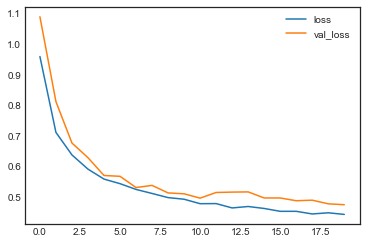

328/328 [==============================] - 52s 159ms/step - loss: 0.4425 - accuracy: 0.8403 - val_loss: 0.4746 - val_accuracy: 0.8348
Training Accuracy: 0.843
Training Loss: 0.959
Validation Accuracy: 0.835
Validation Loss: 1.090


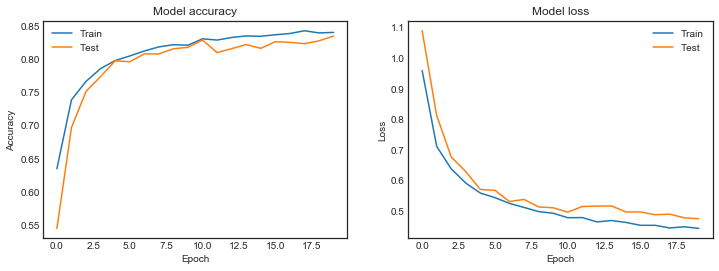

Saved figure at ../../results/figures/None\from_scratch_residual_64x64\model.png
Wall time: 17min 56s


In [6]:
%%time
took = {}
with tf.device("GPU:0"):
    model = train(f_maps = [16, 16, 32, 32],
                  lr = 1e-3,
                  epochs = 20,
                  optimizer = optimizers.Adam,
                  folder = 'from_scratch_residual_64x64',
                  fig_path = 'model.png',
                  model_path = 'model.h5')
# model.summary()

Elucidated from [here](https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md)

In [7]:
def visualize(model, image):
    model_layers = model.layers
    # Extracts the outputs
    layer_outputs = [layer.output for layer in model.layers]
    # Creates a model that will return these outputs, given the model input
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    # get activations
    activations = activation_model.predict(image)
    images_per_row = 4; count = -1
    # Displays the feature maps
    for layer, layer_activation in zip(model_layers, activations):
        if not isinstance(layer, layers.Conv2D):
            continue
        count += 1
        # show first 3 conv layers
        if count == 3:
            break
        n_features = layer_activation.shape[-1] # Number of features in the feature map
        size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
                # Post-processes the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, # Displays the grid
                             row * size : (row + 1) * size] = channel_image
        scale = 2 / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer.name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='gray')
    return [layer.name for layer in model.layers if isinstance(layer, layers.Conv2D)]

In [8]:
images, labels = test_generator.next()

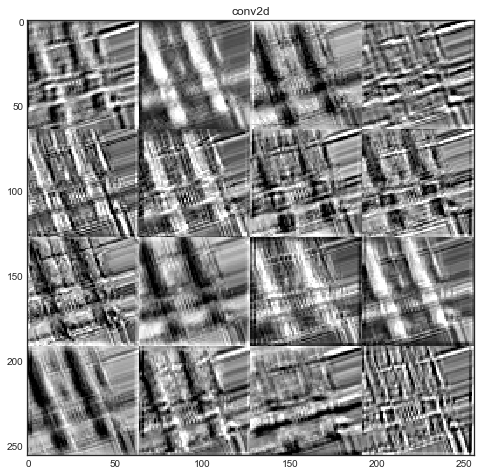

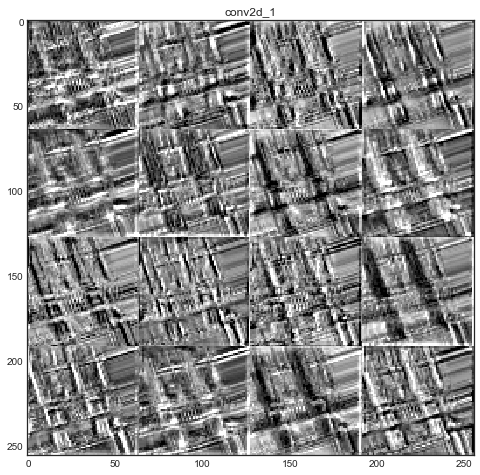

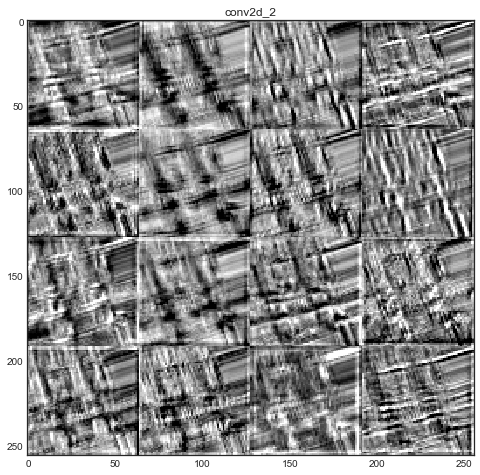

In [9]:
index = 10
image = images[index:index+1]
names = visualize(model, image)

Elucidated from [here](https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/)

In [10]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()
    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs[0]],
            outputs=[self.model.get_layer(self.layerName).output,
                self.model.output])
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        # guidedGrads = guidedGrads[0]
        guidedGrads = grads[0]
        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = ((1 - heatmap) * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap
    def overlay_heatmap(self, heatmap, image, alpha=0.2, colormap=cv2.COLORMAP_JET):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap).reshape(1, img_size, img_size, 3)
        output = image*255*(1-alpha) + heatmap.reshape(1, img_size, img_size, 3)*alpha
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        output = np.uint8(output)
        return (heatmap, output)

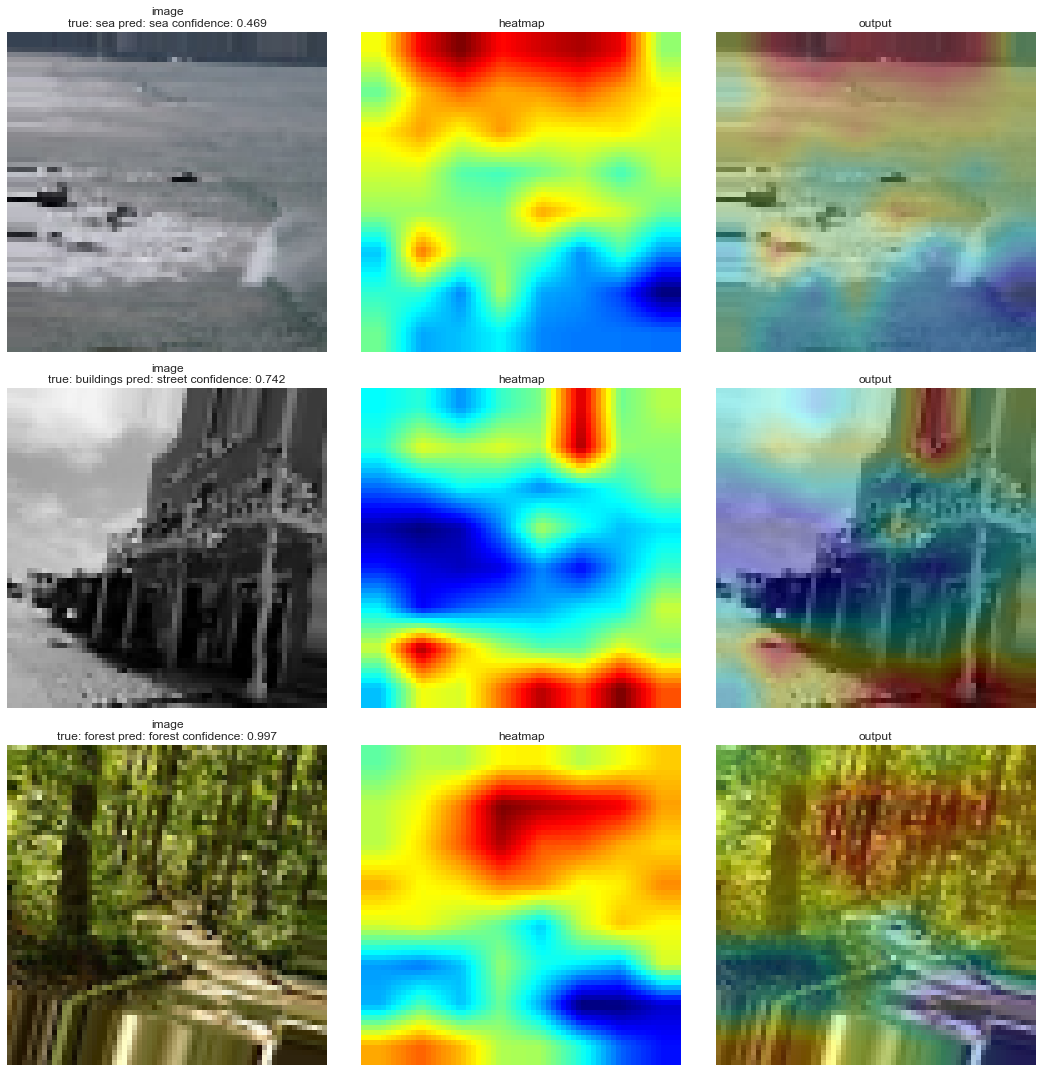

In [11]:
f, axes = plt.subplots(3, 3, figsize=(15, 15))
count = 0
for i in range(9):
    image = images[i//3+count:i//3+1+count]
    preds = model.predict(image)
    index = np.argmax(preds[0])
    # initialize our gradient class activation map and build the heatmap
    cam = GradCAM(model, index, names[-1])
    heatmap = cam.compute_heatmap(image)
    (heatmap, output) = cam.overlay_heatmap(heatmap, image, alpha=0.3)
    description = 'image\ntrue: {} pred: {} confidence: {:.3f}'.format\
    (categories[np.argmax(labels[i//3+count])], categories[index], preds[0][index])
    
    axes[i//3, 0].imshow(image.reshape(img_size, img_size, 3))
    axes[i//3, 1].imshow(heatmap.reshape(img_size, img_size, 3))
    axes[i//3, 2].imshow(output.reshape(img_size, img_size, 3))
    axes[i//3, 0].set_title(description).set_size(12)
    axes[i//3, 1].set_title('heatmap')
    axes[i//3, 2].set_title('output')
    axes[i//3, i%3].axis('off')
plt.tight_layout()

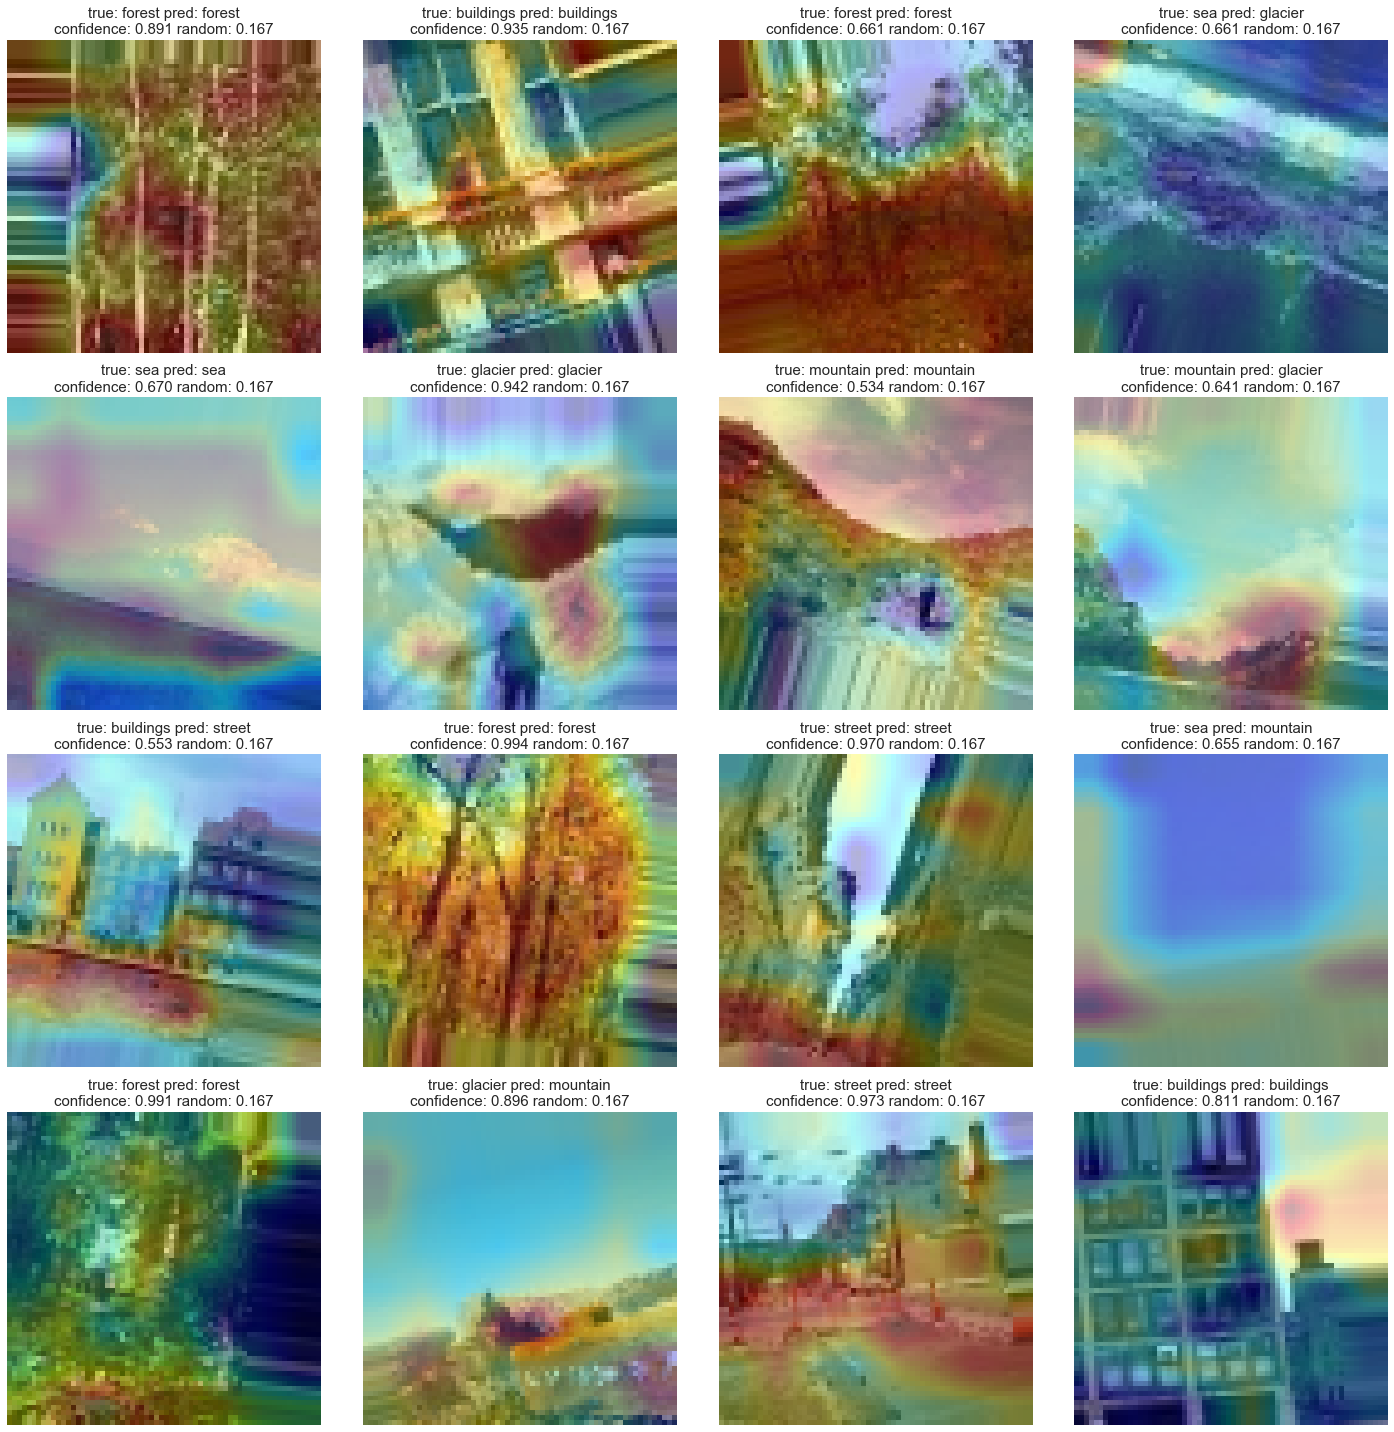

In [12]:
f, axes = plt.subplots(4, 4, figsize=(20, 20))
count = 9
for i in range(16):
    image = images[i+count:i+1+count]
    preds = model.predict(image)
    index = np.argmax(preds[0])
    # initialize our gradient class activation map and build the heatmap
    cam = GradCAM(model, index, names[-1])
    heatmap = cam.compute_heatmap(image)
    (heatmap, output) = cam.overlay_heatmap(heatmap, image, alpha=0.3)
    description = 'true: {} pred: {}\nconfidence: {:.3f} random: {:.3f}'.format\
    (categories[np.argmax(labels[i+count])], categories[index], preds[0][index], 1/len(categories))
    
    axes[i//4, i%4].imshow(output.reshape(img_size, img_size, 3))
    axes[i//4, i%4].set_title(description).set_size(15)
    axes[i//4, i%4].axis('off')
plt.tight_layout()